# Eigenvalues of Symmetric Matrices

In this section we study how a neural network can approximate the mapping  
from a symmetric $3 \times 3$ matrix to its eigenvalues.

**Why this problem?**  
Eigenvalues capture fundamental properties of a matrix — stability, oscillation modes, energy levels — and are central in mathematics, physics, and engineering.  
Since the eigenvalue map is nonlinear, learning it provides a natural benchmark for testing the expressive power of neural networks.

**Setup.**  
We restrict to real symmetric matrices, ensuring that all eigenvalues are real.  
Each matrix is represented by the six independent entries on and above the diagonal.  
For a given matrix

$$
M_i =
\begin{pmatrix}
a & b & c \\
b & d & e \\
c & e & f
\end{pmatrix}
\quad \longrightarrow \quad
x_i = (a, b, c, d, e, f),
\quad
y_i = (\lambda_1, \lambda_2, \lambda_3).
$$

Here $\lambda_1 \leq \lambda_2 \leq \lambda_3$ are the eigenvalues of $M_i$.

**Data.**  
We will generate 10,000 random symmetric matrices with entries uniformly drawn from the range $[-10, 10]$.  
The task of the neural network is to learn the regression map

$$
x_i \;\mapsto\; y_i .
$$

In [ ]:
# === Imports & basic setup ===
from __future__ import annotations

import os, sys, math, random, warnings
from typing import Tuple, Iterable, Optional

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Scikit-learn (for splits and optional scaling)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Matplotlib defaults (readable plots)
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

# Quiet noisy warnings
warnings.filterwarnings("ignore")

# Optional: higher matmul precision on recent PyTorch versions (helps stability on some GPUs/CPUs)
if hasattr(torch, "set_float32_matmul_precision"):
    torch.set_float32_matmul_precision("high")

## Data Generation

To train our neural network we need a dataset of symmetric $3 \times 3$ matrices paired with their eigenvalues.  

**Steps:**
1. Generate random symmetric matrices with entries uniformly sampled from $[-10, 10]$.
2. Extract the six independent entries (on and above the diagonal) as the input vector $x_i$.
3. Compute the eigenvalues of the matrix, sort them in ascending order, and use them as the target vector $y_i$.
4. Store each $(x_i, y_i)$ pair as one row in a dataset.

We will generate 10,000 such examples and store them in a Pandas DataFrame.

In [ ]:


def generate_symmetric_matrix(min_val: float = -10.0, max_val: float = 10.0, dim: int = 3) -> np.ndarray:
    """Generate a random symmetric matrix of shape (dim, dim)."""
    mat = np.random.uniform(min_val, max_val, size=(dim, dim))
    return (mat + mat.T) / 2

# Parameters
num_matrices = 10_000
dim = 3

rows = []
for _ in tqdm(range(num_matrices), desc="Generating matrices"):
    M = generate_symmetric_matrix(dim=dim)
    
    # Extract upper-triangle (including diagonal) as input
    x = [M[i, j] for i in range(dim) for j in range(i, dim)]
    
    # Compute and sort eigenvalues as target
    eigenvalues = np.sort(np.linalg.eigvalsh(M))  # eigvalsh is optimized for symmetric matrices
    
    rows.append(x + list(eigenvalues))

# Assemble DataFrame
columns = [f"M{i}{j}" for i in range(dim) for j in range(i, dim)] + [f"λ{k+1}" for k in range(dim)]
df = pd.DataFrame(rows, columns=columns)

df.head()

## Train–Test Split

To evaluate generalization, we divide the dataset into a training set and a testing set:

- **Training set (80%)**: used to fit the neural network parameters.  
- **Testing set (20%)**: held out and only used to assess model performance.

We use a fixed random seed to make the split reproducible.  
To visualize the split, we display the relative proportions as a pie chart.

In [ ]:
# Split into train/test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

# Sizes
train_size, test_size = len(train_df), len(test_df)
print(f"Number of elements in train set: {train_size}")
print(f"Number of elements in test set: {test_size}")

# Pie chart
labels = ["Train", "Test"]
sizes = [train_size, test_size]
explode = (0.1, 0)  # emphasize the training slice

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct="%1.1f%%", explode=explode,
       shadow=True, startangle=90)
ax.axis("equal")  # equal aspect ratio for a circle
plt.title("Train–Test Split")
plt.show()

## Baseline: Polynomial (Linear) Regression

Before training a neural network, we establish a simple, transparent baseline.

**Idea.** Use a linear model on polynomial features.  
For degree $p$, we map the 6 inputs $(a,b,c,d,e,f)$ to all monomials up to degree $p$ (e.g., for $p=2$: terms like $a^2$, $ab$, $bc$, …).  
Then we fit a model to predict the three eigenvalues $(\lambda_1,\lambda_2,\lambda_3)$.

**Multi-head concept.**  
Our task has three outputs. One way to handle this is to build a **multi-head model**:  
- a **shared body** that processes the inputs (here: the polynomial feature expansion),  
- followed by **separate heads**, one for each eigenvalue.  

Each head is just a simple linear regression on the shared features. This setup reduces computation (we compute the polynomial features only once) and keeps the number of parameters smaller than if we trained three independent models from scratch. In more advanced neural networks, this idea is also very common.

**Why this baseline is useful.**
- Provides a quick performance reference (how far can we go without deep nets?).  
- Highlights the trade-off: higher degree increases expressivity but can overfit and explode the number of features.

We evaluate the mean squared error (MSE) on the held-out test set for degrees $p=1,\dots,P$, pick the best $p$, and also report root mean squared error (RMSE) for each eigenvalue separately.

**RMSE explanation.**  
While MSE averages squared errors over all predictions, RMSE takes the square root:

$$
\text{RMSE}(y,\hat{y}) = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}.
$$

RMSE is measured in the same units as the targets (here: eigenvalues), making it easier to interpret. For example, an RMSE of $0.5$ means that, on average, predictions are within about $0.5$ of the true eigenvalues.

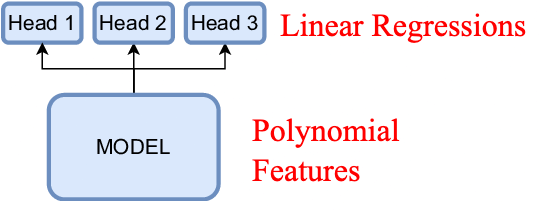

In [ ]:


# --- Prepare features/targets from the existing split (train_df, test_df) ---

# Columns from earlier data generation: [M00, M01, M02, M11, M12, M22, λ1, λ2, λ3]
eig_cols = [c for c in df.columns if c.startswith("λ")]
feat_cols = [c for c in df.columns if c not in eig_cols]

X_train = train_df[feat_cols].to_numpy()
y_train = train_df[eig_cols].to_numpy()
X_test  = test_df[feat_cols].to_numpy()
y_test  = test_df[eig_cols].to_numpy()

# --- Sweep polynomial degrees and evaluate on the test set ---
max_deg = 8
records = []

for deg in range(1, max_deg + 1):
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
        ("scaler", StandardScaler()),                     # scale expanded features
        ("linreg", LinearRegression())
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)             # averaged over all 3 targets
    rmse_per_target = np.sqrt(((y_test - y_pred) ** 2).mean(axis=0))  # RMSE per eigenvalue

    records.append({
        "degree": deg,
        "MSE": mse,
        "RMSE_λ1": rmse_per_target[0],
        "RMSE_λ2": rmse_per_target[1],
        "RMSE_λ3": rmse_per_target[2],
        "n_features_after_poly": model.named_steps["poly"].n_output_features_
    })

results_df = pd.DataFrame(records)
display(results_df)

# --- Plot MSE vs degree ---
plt.figure(figsize=(7, 4))
plt.plot(results_df["degree"], results_df["MSE"], marker="o")
plt.xlabel("Polynomial degree")
plt.ylabel("Test MSE (averaged over λ1, λ2, λ3)")
plt.title("Polynomial Regression Baseline: MSE vs Degree")
plt.grid(True)
plt.show()

# --- Pick the best degree and report a concise summary ---
best_idx = results_df["MSE"].idxmin()
best_row = results_df.loc[best_idx]
best_degree = int(best_row["degree"])

print(f"Best polynomial degree: {best_degree}")
print(f"Best test MSE: {best_row['MSE']:.6f}")
print(f"Per-eigenvalue RMSE at degree {best_degree}: "
      f"λ1={best_row['RMSE_λ1']:.4f}, λ2={best_row['RMSE_λ2']:.4f}, λ3={best_row['RMSE_λ3']:.4f}")
print(f"Number of polynomial features at degree {best_degree}: {int(best_row['n_features_after_poly'])}")

# Optional: expose a simple loss_dict for later comparison with NN
loss_dict = {}
loss_dict["Polynomial baseline (best MSE)"] = float(best_row["MSE"])

## Simple Neural Network

We now fit a small multi-layer perceptron (MLP) that maps the 6 input features to the three eigenvalues $(\lambda_1,\lambda_2,\lambda_3)$.

**Normalization.**  
We standardize features using `StandardScaler` (fit on the training set only) so that all inputs have zero mean and unit variance. This often stabilizes and speeds up training.

**Model.**  
A simple MLP with two hidden layers and ReLU nonlinearity. The final layer has 3 outputs—think of this as a single shared body with a 3-dimensional “head” producing $(\lambda_1,\lambda_2,\lambda_3)$ simultaneously.

**Loss and optimization.**  
We use MSE loss and Adam optimizer. We track train/test losses across epochs and plot learning curves.

*(In the next sections we will add Dropout and BatchNorm to study regularization and normalization.)*

In [ ]:
scaler = StandardScaler().fit(X_train)   # fit on train only
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train,         dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,          dtype=torch.float32)

X_train_t.shape, y_train_t.shape, X_test_t.shape, y_test_t.shape

### Model definition

The input size equals the number of unique entries in a symmetric $3\times 3$ matrix (6 features).  
The last layer outputs 3 numbers (a multi-output head), one per eigenvalue.

In [ ]:
class EigenvalueNet(nn.Module):
    def __init__(self, dim: int = 3, hidden: int = 64):
        super().__init__()
        input_size = dim * (dim + 1) // 2  # 6 for dim=3
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim)          # multi-output (λ1, λ2, λ3)
        )

    def forward(self, x):
        return self.net(x)

model = EigenvalueNet(dim=3, hidden=64)
model

### Training loop 

- Each epoch:
  1. `model.train()` → iterate over mini-batches, backprop, update weights, accumulate average train MSE.
  2. `model.eval()` → disable gradients, run on test set, compute average test MSE.
- We print progress every few epochs.
- Optional: gradient-norm logging (for debugging) and gradient clipping (stability).

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.utils as nn_utils

def make_loaders(X_train_t, y_train_t, X_test_t, y_test_t, batch_size=64):
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=100,
    log_every=20,
    grad_clip=None,          # e.g., 1.0; set None to disable
    log_grads=False,         # print gradient norms
    scheduler=None           # optional torch.optim.lr_scheduler
):
    train_losses, test_losses = [], []

    for epoch in range(1, epochs + 1):
        # --------- Train ---------
        model.train()
        total_train_loss, n_train = 0.0, 0

        for xb, yb in train_loader:
            pred = model(xb)
            loss = criterion(pred, yb)

            optimizer.zero_grad()
            loss.backward()

            if grad_clip is not None:
                nn_utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()

            # accumulate for epoch average
            bs = xb.size(0)
            total_train_loss += loss.item() * bs
            n_train += bs

            if log_grads:
                # print (or collect) gradient norms for each layer (optional, lightweight)
                with torch.no_grad():
                    norms = {name: (p.grad.norm().item() if p.grad is not None else 0.0)
                             for name, p in model.named_parameters()}
                # You can print selectively; here we keep it quiet by default
                # print({k: f"{v:.3f}" for k, v in norms.items()})

        train_loss = total_train_loss / max(n_train, 1)
        train_losses.append(train_loss)

        # --------- Evaluate ---------
        model.eval()
        total_test_loss, n_test = 0.0, 0
        with torch.no_grad():
            for xb, yb in test_loader:
                pred = model(xb)
                loss = criterion(pred, yb)
                bs = xb.size(0)
                total_test_loss += loss.item() * bs
                n_test += bs

        test_loss = total_test_loss / max(n_test, 1)
        test_losses.append(test_loss)

        # --------- Scheduler (optional) ---------
        if scheduler is not None:
            scheduler.step()

        if (epoch % log_every == 0) or (epoch == 1) or (epoch == epochs):
            print(f"Epoch {epoch:3d} | train MSE: {train_loss:.6f} | test MSE: {test_loss:.6f}")

    return train_losses, test_losses

In [ ]:
# Build loaders
train_loader, test_loader = make_loaders(X_train_t, y_train_t, X_test_t, y_test_t, batch_size=64)

# Define model/opt/criterion
model = EigenvalueNet(dim=3, hidden=64)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train
train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=100,
    log_every=20,
    grad_clip=None,   # set to 1.0 if you see instability
    log_grads=False
)

### Learning curves

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Train MSE")
plt.plot(test_losses,  label="Test MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training and Testing Loss Curves (Simple NN)")
plt.grid(True)
plt.legend()
plt.show()

### Evaluation: per-eigenvalue RMSE

To compare with the polynomial baseline, we compute:
- overall **MSE**, **MAE**, **RMSE** on the test set,
- **per-eigenvalue RMSE** for $(\lambda_1,\lambda_2,\lambda_3)$.

Optionally, we can sort the model’s outputs at evaluation time to match the target ordering.

In [ ]:
import numpy as np
import torch

def evaluate_on_loader(model, loader, sort_outputs: bool = False):
    """Evaluate model on a DataLoader and return metrics.
    
    Args:
        model: trained nn.Module
        loader: DataLoader with (X, y)
        sort_outputs: if True, sort each prediction vector ascending to match (λ1 ≤ λ2 ≤ λ3)
    Returns:
        metrics dict with overall MSE/MAE/RMSE and per-eigenvalue RMSE array
    """
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            pb = model(xb)
            if sort_outputs:
                pb, _ = torch.sort(pb, dim=1)  # enforce ordering at eval
            preds.append(pb.cpu().numpy())
            targets.append(yb.cpu().numpy())
    y_pred = np.concatenate(preds, axis=0)
    y_true = np.concatenate(targets, axis=0)

    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(mse)
    rmse_per = np.sqrt(np.mean((y_true - y_pred) ** 2, axis=0))

    return {
        "MSE": float(mse),
        "MAE": float(mae),
        "RMSE": float(rmse),
        "RMSE_per": rmse_per
    }

# Example usage on the test set:
metrics = evaluate_on_loader(model, test_loader, sort_outputs=False)
print(f"Test MSE : {metrics['MSE']:.6f}")
print(f"Test MAE : {metrics['MAE']:.6f}")
print(f"Test RMSE: {metrics['RMSE']:.6f}")
print("Per-eigenvalue RMSE (λ1, λ2, λ3):",
      ", ".join(f"{v:.6f}" for v in metrics["RMSE_per"]))

In [ ]:
import matplotlib.pyplot as plt

def scatter_pred_vs_true(model, loader, titles=("λ1","λ2","λ3"), sort_outputs=False):
    model.eval()
    with torch.no_grad():
        y_true_list, y_pred_list = [], []
        for xb, yb in loader:
            pb = model(xb)
            if sort_outputs:
                pb, _ = torch.sort(pb, dim=1)
            y_true_list.append(yb.cpu().numpy())
            y_pred_list.append(pb.cpu().numpy())
    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)

    cols = y_true.shape[1]
    for k in range(cols):
        plt.figure(figsize=(5,4))
        plt.scatter(y_true[:,k], y_pred[:,k], s=8, alpha=0.5)
        mn = min(y_true[:,k].min(), y_pred[:,k].min())
        mx = max(y_true[:,k].max(), y_pred[:,k].max())
        plt.plot([mn, mx], [mn, mx])
        plt.xlabel("True")
        plt.ylabel("Predicted")
        plt.title(f"Predicted vs True — {titles[k]}")
        plt.grid(True)
        plt.show()

# Example:
scatter_pred_vs_true(model, test_loader, sort_outputs=False)

### Comparison: Polynomial Baseline vs Neural Network

To summarize results, we collect test MSE values from:
- the best polynomial regression baseline,
- the trained neural network.

This lets us quickly see how much the neural network improves (or not) over a strong but simple baseline.

In [ ]:
# Start dictionary with baseline
loss_dict = {}
loss_dict["Polynomial baseline (best MSE)"] = float(best_row["MSE"])

# Evaluate NN on test set
nn_metrics = evaluate_on_loader(model, test_loader, sort_outputs=False)

loss_dict["Neural network (MSE)"] = nn_metrics["MSE"]
# loss_dict["Neural network (RMSE)"] = nn_metrics["RMSE"]

# Show results
for k, v in loss_dict.items():
    print(f"{k:35s}: {v:.6f}")

print("Per-eigenvalue RMSE (λ1, λ2, λ3):",
      ", ".join(f"{v:.6f}" for v in nn_metrics["RMSE_per"]))

## Deep Neural Networks

**Why study neural networks?**  
A fundamental reason behind their success is the _Universal Approximation Theorem_. One formulation states:

> Feedforward networks with a non-polynomial activation function are dense in the space of continuous functions between Euclidean spaces.

In plain terms: with enough width/depth and the right nonlinearity (e.g., ReLU), a feedforward network can approximate any continuous function on a compact domain arbitrarily well.

**Important caveats.**
- The theorem is _existential_: it does not specify how large the network must be or how to find the weights by optimization.
- Approximation power does not imply good **generalization** or easy **optimization**.
- Larger networks can overfit; we will later study **Dropout** and **Batch Normalization** to improve training dynamics and generalization.

**Experiment.**  
We now construct a substantially deeper MLP that maps the 6 inputs to the three outputs $(\lambda_1,\lambda_2,\lambda_3)$ and compare its performance to the polynomial baseline.|

### 1.2.1 Big Neural Network

There can be an idea that we can take a big Neural Network and get good results.

In [ ]:
def build_mlp(input_dim: int, output_dim: int, hidden: int = 32, depth: int = 12, activation=nn.ReLU) -> nn.Sequential:
    """
    Build an MLP with `depth` hidden layers of size `hidden`.
    Final layer has `output_dim` units (multi-output head).
    """
    layers = [nn.Linear(input_dim, hidden), activation()]
    for _ in range(depth - 1):
        layers += [nn.Linear(hidden, hidden), activation()]
    layers += [nn.Linear(hidden, output_dim)]
    return nn.Sequential(*layers)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Problem dimensions
dim = 3
input_size  = dim * (dim + 1) // 2  # 6 features for a 3x3 symmetric matrix
output_size = dim

# Build a deeper model (you suggested many ReLU blocks with width 32)
deep_width = 32
deep_depth = 12  # number of hidden layers
big_model = build_mlp(input_dim=input_size, output_dim=output_size, hidden=deep_width, depth=deep_depth, activation=nn.ReLU)

print(big_model)
print(f"Trainable parameters: {count_parameters(big_model):,}")

### 1.2.2 Training loop

Let's train it.

In [ ]:
# Train the deep model with the same loop and loaders used before
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(big_model.parameters(), lr=1e-3)

deep_train_losses, deep_test_losses = train_model(
    big_model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=500,
    log_every=20
)

# Evaluate
deep_metrics = evaluate_on_loader(big_model, test_loader, sort_outputs=False)
print(f"Deep NN — Test MSE : {deep_metrics['MSE']:.6f}")
print(f"Deep NN — Test MAE : {deep_metrics['MAE']:.6f}")
print(f"Deep NN — Test RMSE: {deep_metrics['RMSE']:.6f}")
print("Deep NN — Per-eigenvalue RMSE (λ1, λ2, λ3):",
      ", ".join(f"{v:.6f}" for v in deep_metrics["RMSE_per"]))

In [ ]:
# Learning curves for the deep network
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(deep_train_losses, label="Train MSE (deep NN)")
plt.plot(deep_test_losses,  label="Test MSE (deep NN)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title(f"Deep NN Learning Curves (depth={deep_depth}, width={deep_width})")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Add to comparison table/dict
loss_dict["Deep NN (MSE)"]  = deep_metrics["MSE"]
# loss_dict["Deep NN (RMSE)"] = deep_metrics["RMSE"]

# Pretty print comparison
print("\n=== Test-set comparison ===")
for k, v in loss_dict.items():
    print(f"{k:35s}: {v:.6f}")

## Conclusion: Baseline vs Neural Networks (May differ with changes)

Our experiments show a clear progression in approximation power:

- **Polynomial baseline:** achieves a reasonable fit, but performance is limited and feature count grows rapidly with degree.  
- **Simple neural network:** substantially improves over the polynomial model, demonstrating the strength of learned nonlinear representations.  
- **Deep neural network:** provides the best accuracy among our models, benefiting from additional layers and parameters.

**Takeaway.**  
Neural networks clearly outperform polynomial regression for this task.  
The polynomial model is useful as a sanity check, but it becomes unwieldy at higher degrees. Neural networks scale more gracefully, represent richer nonlinear functions, and achieve stronger performance without manual feature engineering.

In the next sections, we will introduce **regularization techniques** (Dropout, BatchNorm) to help deeper networks train more stably and generalize more effectively.

# Regularization and Normalization Techniques

Modern deep nets train well when two things are controlled:
1) the **scale** of signals and gradients as they flow through layers, and
2) the model’s **capacity** to overfit.

Normalization primarily addresses (1); regularization primarily addresses (2). In practice, both interact.

## Vanishing/Exploding Gradients (intuition)

Backpropagation multiplies Jacobians across layers. In a simplified diagonal case,
$$
W = W_1 W_2 \cdots W_L,
$$
if typical singular values of the $W_\ell$ are $<1$, products shrink (vanishing); if $>1$, products blow up (exploding).  
This motivates keeping **activations and gradients in reasonable ranges** using good initialization and normalization.

## Initialization (quick guide)

Let $n_{\text{in}}$ and $n_{\text{out}}$ be fan-in/out of a linear layer.

- **He (Kaiming) initialization** — good for ReLU-like activations:
  - Normal: $\;\sigma^2 = \dfrac{2}{n_{\text{in}}}$
  - Uniform: $\;w \sim \mathcal U\!\Big(-\sqrt{\tfrac{6}{n_{\text{in}}}}, \sqrt{\tfrac{6}{n_{\text{in}}}}\Big)$
- **Xavier (Glorot) initialization** — good for tanh/sigmoid:
  - Normal: $\;\sigma^2 = \dfrac{2}{n_{\text{in}}+n_{\text{out}}}$
  - Uniform: $\;w \sim \mathcal U\!\Big(-\sqrt{\tfrac{6}{n_{\text{in}}+n_{\text{out}}}}, \sqrt{\tfrac{6}{n_{\text{in}}+n_{\text{out}}}}\Big)$

> PyTorch offers these in `torch.nn.init` and often uses sensible defaults.

## Batch Normalization (BN)

Given a mini-batch $X \in \mathbb R^{B \times d}$ (B: batch size, d: features), BN computes
$$
\hat X = \frac{X - \mu_{\text{batch}}}{\sqrt{\sigma^2_{\text{batch}} + \varepsilon}},\qquad
Y = \gamma \odot \hat X + \beta,
$$
where $\gamma,\beta \in \mathbb R^d$ are learnable **scale/shift** parameters.

- **Training:** uses batch statistics $(\mu_{\text{batch}}, \sigma^2_{\text{batch}})$ and updates running estimates.
- **Inference:** uses the **running** mean/variance (fixed), not the current batch.
- **Placement:** the common recipe is `Linear → BN → Activation`. (Other orders can work but are less standard.)
- **Why it helps:** more stable signal scales, smoother loss landscape, larger viable learning rates.

**Caveats.**
- Too small batches make BN stats noisy (consider LayerNorm/GroupNorm in that case).
- BN is not a regularizer per se (though it can have a mild regularizing effect); combine with Dropout/weight decay when needed.

In [ ]:
def build_mlp_bn(input_dim: int, output_dim: int, hidden: int = 32, depth: int = 12, activation=nn.ReLU) -> nn.Sequential:
    """
    Deep MLP with BatchNorm after each Linear (except the last).
    Pattern: Linear -> BN -> Activation, repeated 'depth' times, then final Linear to outputs.
    """
    layers = []
    # first block
    layers += [nn.Linear(input_dim, hidden), nn.BatchNorm1d(hidden), activation()]
    # middle blocks
    for _ in range(depth - 1):
        layers += [nn.Linear(hidden, hidden), nn.BatchNorm1d(hidden), activation()]
    # head
    layers += [nn.Linear(hidden, output_dim)]
    return nn.Sequential(*layers)

dim = 3
input_size  = dim * (dim + 1) // 2  # 6 features
output_size = dim
bn_width, bn_depth = 32, 12

big_model_BN = build_mlp_bn(input_dim=input_size, output_dim=output_size,
                            hidden=bn_width, depth=bn_depth, activation=nn.ReLU)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(big_model_BN.parameters(), lr=1e-3)

bn_train_losses, bn_test_losses = train_model(
    big_model_BN, train_loader, test_loader, criterion, optimizer,
    epochs=500, log_every=20
)

bn_metrics = evaluate_on_loader(big_model_BN, test_loader, sort_outputs=False)
print(f"BN Deep NN — Test MSE : {bn_metrics['MSE']:.6f}")
print(f"BN Deep NN — Test MAE : {bn_metrics['MAE']:.6f}")
print(f"BN Deep NN — Test RMSE: {bn_metrics['RMSE']:.6f}")
print("BN Deep NN — Per-eigenvalue RMSE (λ1, λ2, λ3):",
      ", ".join(f"{v:.6f}" for v in bn_metrics["RMSE_per"]))

In [ ]:
# Plot learning curves for the BN model
plt.figure(figsize=(7,4))
plt.plot(bn_train_losses, label="Train MSE (BN deep NN)")
plt.plot(bn_test_losses,  label="Test MSE (BN deep NN)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title(f"Deep NN + BatchNorm (depth={bn_depth}, width={bn_width})")
plt.grid(True)
plt.legend()
plt.show()

## 2.1 Gradient vanishing and explosion

Consider the multiplication of diagonal matrices: $$W = W_1 W_2 \dots W_n.$$ If the eigenvalues of each $W_i$ are less than 1, then the product $W$ will quickly converge to a small matrix. Conversely, if the eigenvalues of each $W_i$  are greater than 1, the product $W$ will grow exponentially.

With Neural Networks it lead to the idea, that on each layers *parameters* and *gradients* should ideally <ins>be kept within a reasonable range or normalized</ins>.

## 2.2 Initialization of Layers

Here are a few tips for initializing layer weights:

1. **Default Initialization**: Often, you don't need to explicitly initialize weights; PyTorch may provide reasonable defaults.
2. **He Initialization**: A common approach is to initialize weights within the range $[-y, y]$, where $y = \frac{1}{\sqrt{n}}$ and 'n' is the number of inputs to a neuron.
3. **Xavier Initialization**: Xavier initialization is theoretically well-founded in certain situations ([Understanding the difficulty of training deep feedforward neural networks - Glorot, X. & Bengio, Y. (2010)](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)).

PyTorch Docs:
https://pytorch.org/docs/stable/nn.init.html#torch-nn-init


## 2.2 Batch Normalization

Normalization techniques aim to make data samples more similar, improving model learning and generalization. There are several normalization layers: [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) (introduced in 2015), [ instance normalization](https://pytorch.org/docs/stable/generated/torch.nn.InstanceNorm1d.html), [layer normalization ](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)

Let's consider batch normalization.

1. First, the **batch normalization layer** is applied, normalizing the current batch to have zero mean and unit variance: $$X^{k+1} = \frac{X^k-\mu}{\sqrt{\sigma^2 + \varepsilon}},$$ where $\mu$ and $\sigma^2$ are the average and variance of features for the processed batch. Note that $\mu^2$ and $\sigma^2$, being functions of $X^k$, also participate in the calculation of gradients. <ins>During inference they must be fixed</ins>.

2. A **channel-wise scaling** layer follows, learning optimal scaling for all features $X^{k+2}$. This layer applies the transformation $$X^{k+2} = \beta X^{k+1} + \gamma,$$ where $\beta$ and $\gamma$ are learnable parameters, adjusting the mean and variance of the output $X^{k+2}$ during training.

### 2.2.1 Using BN

<font color='blue'>**Question**: Should Batch Normalization precede or follow after an Activation function?</font>

The order

```
Linear → BatchNorm → Activation
```

makes more sence. As a side note, this ordering best practice is not a law. With other order your model will still train, and you may see better results.

In [ ]:
dim = 3
input_size, hidden_size, output_size = dim * (dim + 1) // 2, 32, dim

big_model_BN = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(big_model_BN.parameters(), lr=0.001)
train_loss_BN, test_loss_BN = training_loop(big_model_BN, X_train_scaled, y_train,
                                              X_test_scaled, y_test,
                                              criterion, optimizer,
                                              print_grad=True)

While the loss increased slightly, the training curve became significantly smoother. Very deep NN can not be trained without normalization techniques.

In [ ]:
draw_loss(train_loss_BN, test_loss_BN, title='Big NN + BN')

In [ ]:
loss_dict["Simple NN + BN loss"] = test_loss_BN[-1]
print(test_loss_BN[-1])

Batch normalization's effectiveness is still a mystery.  Numerous hypotheses exist, but no definitive explanation has emerged.  This uncertainty is common in deep learning, best practices are usually found in experiments rather than in theory.

## 2.3 Dropout

Another problem with big NN is that they can easily **overfit**. Once overfitting begins, the focus shifts to improving generalization through regularization. Standard strategies include:

1.   reducing model capacity,
2.   early stopping,
3.   weight regularization,
4.   and **dropout**.

As a side note, a larger or higher-quality dataset remains the most effective way to enhance generalization.

**Dropout**, applied to a layer, consists of randomly dropping out
(setting to zero) a number of output features of the layer during training.

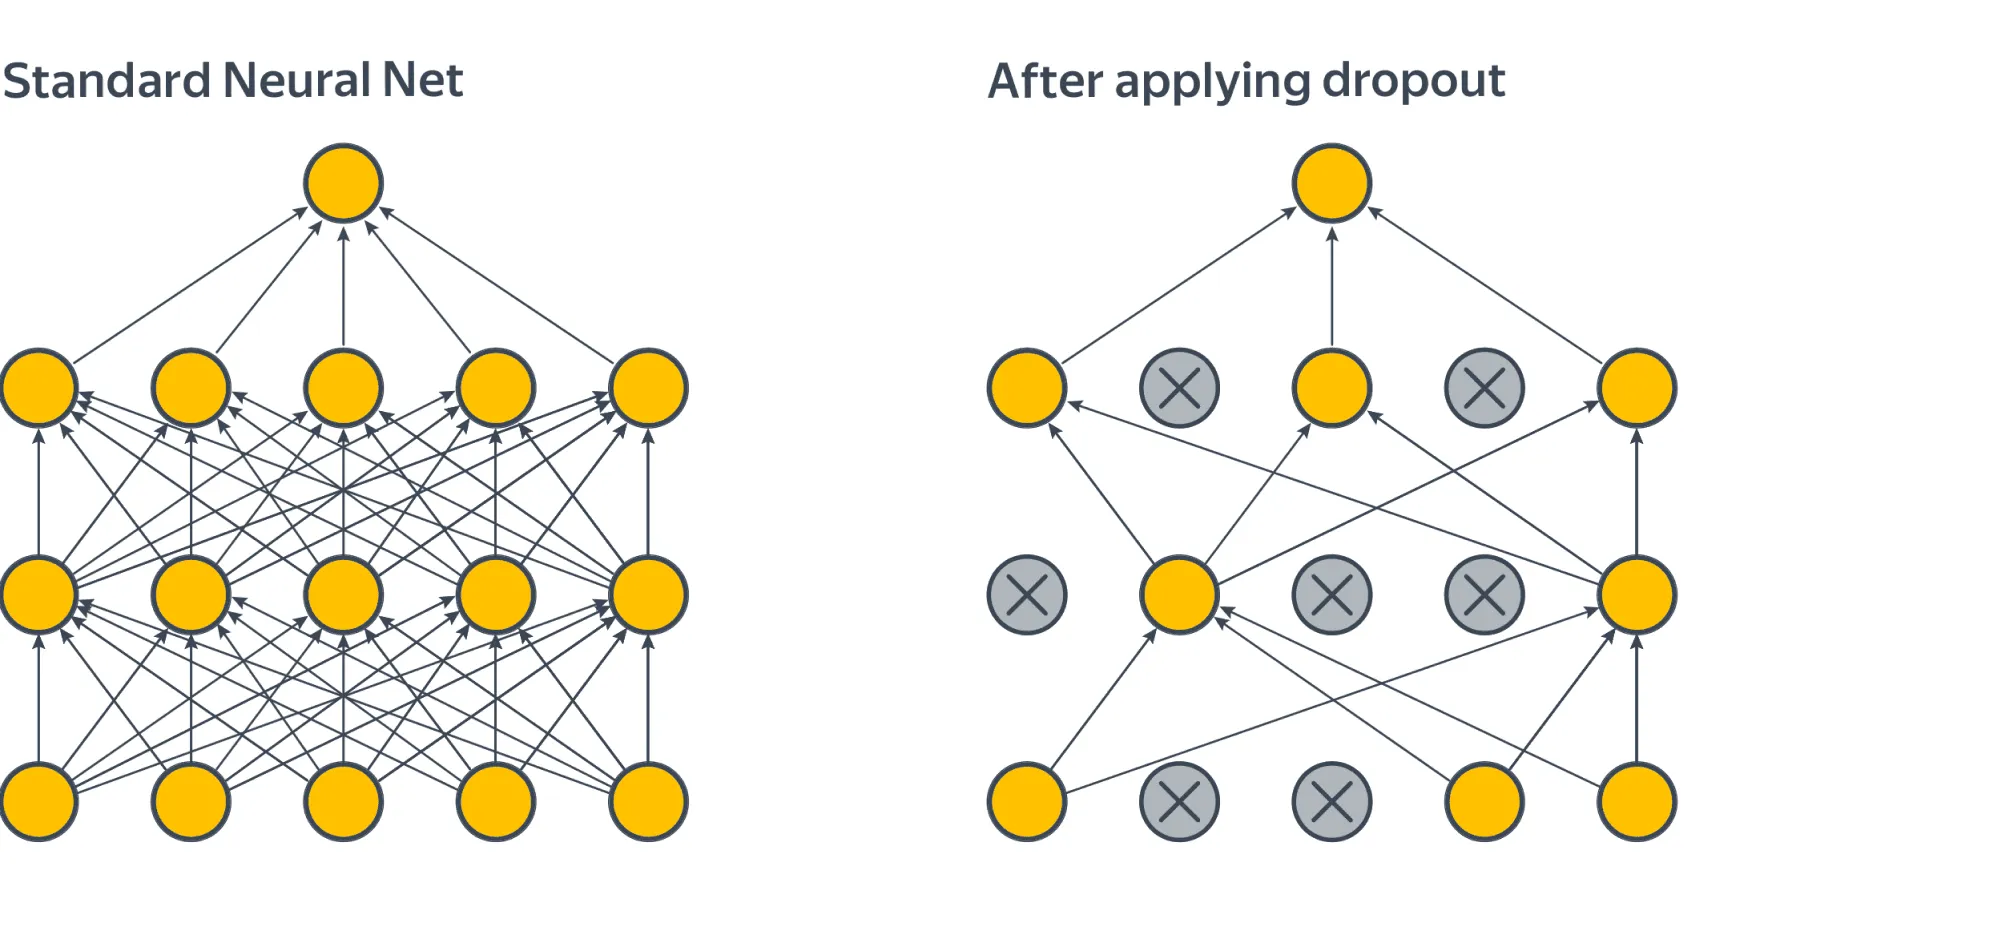

Techinically another transformation is added, which is the multiplication of the output of the previous layer by a mask of zeros and ones. $$x_{k+1} = \frac{1}{1-p}x^k \odot mask_i, \qquad mask_i \sim \operatorname{Bernoulli}(1-p),$$ where $p$ (probability of coordinate zeroing) is the hyperparameter of the layer. <ins>On inference dropout must be turn-off</ins> (also, note that we multiply on $\frac{1}{1-p}$, to balance for the fact that more units are
active than at training time).


<font color='blue'>**Question**: Why would this help reduce overfitting?</font>

Drop-out was introduced in 2014 by Geoff Hinton and his student. He described the idea behind the Drop-out as follows:

> “I went to my bank. The tellers kept changing
and I asked one of them why. He said he didn’t know but they got moved around a lot I figured it must be because it would require cooperation between employees to successfully defraud the bank. This made me realize that randomly removing a different
subset of neurons on each example would prevent conspiracies and thus reduce overfitting.”


In [ ]:
dim = 3
input_size, hidden_size, output_size = dim * (dim + 1) // 2, 32, dim

big_model_DO = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, output_size)
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(big_model_DO.parameters(), lr=0.001)
train_loss_DO, test_loss_DO = training_loop(big_model_DO, X_train_scaled, y_train,
                                              X_test_scaled, y_test,
                                              criterion, optimizer, num_epochs=200, print_grad=False)

In [ ]:
draw_loss(train_loss_DO, test_loss_DO, title='Big NN + BN')

In [ ]:
loss_dict["Simple NN + DO loss"] = test_loss_DO[-1]
test_loss_DO[-1]

This time Dropout only made the situation worse. BN and Dropout may not go well together. As the creators of BatchNormalization noted (https://arxiv.org/pdf/1502.03167):

>"Whereas Dropout is typically used to reduce overfitting, a batch-normalized network we found that it can be either removed or reduced in strength".

In [ ]:
dim = 3
input_size, hidden_size, output_size = dim * (dim + 1) // 2, 32, dim

big_model_BN_DO = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_size, output_size)
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(big_model_BN_DO.parameters(), lr=0.001)
train_loss_BN_DO, test_loss_BN_DO = training_loop(big_model_BN_DO, X_train_scaled, y_train,
                                              X_test_scaled, y_test,
                                              criterion, optimizer, num_epochs=200, print_grad=False)

draw_loss(train_loss_BN_DO, test_loss_BN_DO, title='Big NN + BN + DO')
test_loss_BN_DO[-1]


In [ ]:
loss_dict["Simple NN + BN + DO loss"] = test_loss_BN_DO[-1]

loss_df = pd.DataFrame.from_dict(loss_dict, orient='index', columns=['Loss'])

loss_df

# for key, value in loss_dict.items():
    # print(f"{key}: {value}")


### Key takeaways:

1. Address potential **gradient vanishing/explosion** by using appropriate initialization, batch normalization, and dropout.
2. Larger neural networks do not always guarantee better performance.


<font color='red'>**Advice:**</font>

1. When available, <ins>leverage parameters from relevant research publications</ins> as a starting point.
2. Start with a basic neural network architecture and gradually increase its complexity, adding one component at a time.
